Train Regression (3 CLIP scores error, and T -> predict best T) Model

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import random

random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


Load Data

In [3]:
save_path = Path('/home/lbw/CLODE_scores_npy')

# (485, 2): 485개 이미지에 대한, best T값과 그때의 PSNR
results = np.load(save_path / 'results.npy')

# (485 * 30, 3): 485개 이미지에 대한, 30개의 T값에 대한 score. 3 = [idx, T, score]
brightness_scores = np.load(save_path / 'brightness_scores.npy')
noisiness_scores = np.load(save_path / 'noisiness_scores.npy')
quality_scores = np.load(save_path / 'quality_scores.npy')

print(results.shape, brightness_scores.shape, noisiness_scores.shape, quality_scores.shape)

(485, 2) (14550, 3) (14550, 3) (14550, 3)


In [33]:
print(brightness_scores[:31, 1])

[2.         2.10344828 2.20689655 2.31034483 2.4137931  2.51724138
 2.62068966 2.72413793 2.82758621 2.93103448 3.03448276 3.13793103
 3.24137931 3.34482759 3.44827586 3.55172414 3.65517241 3.75862069
 3.86206897 3.96551724 4.06896552 4.17241379 4.27586207 4.37931034
 4.48275862 4.5862069  4.68965517 4.79310345 4.89655172 5.
 2.        ]


In [4]:
NUM_IMAGES = results.shape[0]
NUM_T = 30

In [ ]:
from torchmetrics.multimodal import CLIPImageQualityAssessment
from tqdm import tqdm
from misc import *

prompts = ('brightness', 'noisiness', 'quality')
clip_metric = CLIPImageQualityAssessment(model_name_or_path="openai/clip-vit-base-patch16", prompts=prompts).to(device)

file_path = Path('/home/soom/data/our485')
img_labels = sorted(os.listdir(file_path / 'low'))

def calculate_clip_scores(pred):    
    clip_result = clip_metric(pred.unsqueeze(0) if len(pred.shape) == 3 else pred)
    scores = [clip_result[prompt].item() for prompt in prompts]
    
    return scores

lq_iqa_scores = []

with torch.no_grad():
    for idx in tqdm(range(NUM_IMAGES)):
        lq_t = image_tensor(file_path / 'low' / img_labels[idx], size=(256, 256))
        scores = calculate_clip_scores(lq_t)
        lq_iqa_scores.append(scores)

In [5]:
lq_iqa_scores = np.load(Path('/home/soom/CLODE/soom_npy_results') / 'lq_iqa_scores.npy')
print(lq_iqa_scores.shape)

(485, 3)


In [6]:
X = np.zeros((NUM_IMAGES, NUM_T, 4))

for i in range(NUM_IMAGES):
    for j in range(NUM_T):
        X[i, j, 0] = brightness_scores[i * NUM_T + j, 2] - lq_iqa_scores[i][0]
        X[i, j, 1] = noisiness_scores[i * NUM_T + j, 2] - lq_iqa_scores[i][1]
        X[i, j, 2] = quality_scores[i * NUM_T + j, 2] - lq_iqa_scores[i][2]
        X[i, j, 3] = brightness_scores[i, 1]        # T value

y = results[:, 0]

X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

print(X.shape, y.shape)

torch.Size([485, 30, 4]) torch.Size([485])


In [7]:
# normalize
X[:, :, :-1] = (X[:, :, :-1] - X[:, :, :-1].mean(dim=1).unsqueeze(1)) / X[:, :, :-1].std(dim=1).unsqueeze(1)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([388, 30, 4]) torch.Size([97, 30, 4]) torch.Size([388]) torch.Size([97])


In [9]:
batch_size = 16
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

Load Model

In [10]:
class Regressor(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64):
        super(Regressor, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.transformer_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim*2)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=2)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        # [batch_size, T, hidden_dim]
        x = self.mlp(x)
        # [seq_len = T, batch, hidden_dim]
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        # [batch, hidden_dim]
        x = x.permute(1, 0, 2).mean(dim=1)
        # [batch, 1]
        T_pred = self.fc(x).squeeze(-1)
        return T_pred

Train the Model

In [11]:
from tqdm import tqdm

num_epochs = 2000
train_losses = []
test_losses = []
best_test_loss = 10
best_epoch = 0
learning_rate = 1e-4

regressor = Regressor(input_dim = 4, hidden_dim = 64).to(device)
criterion = torch.nn.HuberLoss(delta=1.0)
optimizer = optim.Adam(regressor.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)


for epoch in tqdm(range(num_epochs)):
    regressor.train()
    epoch_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        y_pred = regressor(X_batch)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))
    
    regressor.eval()
    test_loss = 0.0
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_pred = regressor(X_batch)
            test_loss += criterion(y_pred, y_batch).item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model = regressor.state_dict()
            best_epoch = epoch


model_path = Path("/home/soom/CLODE/soom_outputs")
model_path.mkdir(exist_ok=True, parents=True)

torch.save(best_model, (model_path / f'att_regression_{best_epoch}.pth'))

/home/soom/miniconda3/envs/clode/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/soom/miniconda3/envs/clode/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 2000/2000 [08:17<00:00,  4.02it/s]


Plot Train Result and Performance

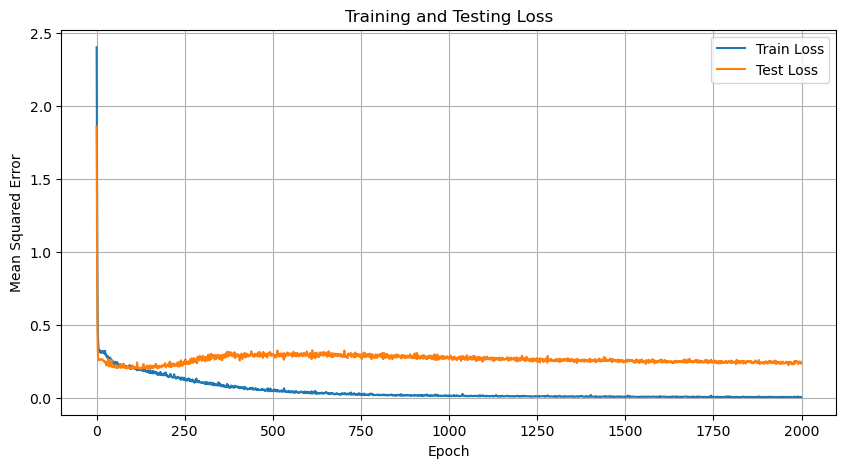

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.savefig(model_path / 'regression_training.png')
plt.show()

MAE: 0.1308, RMSE: 0.1507


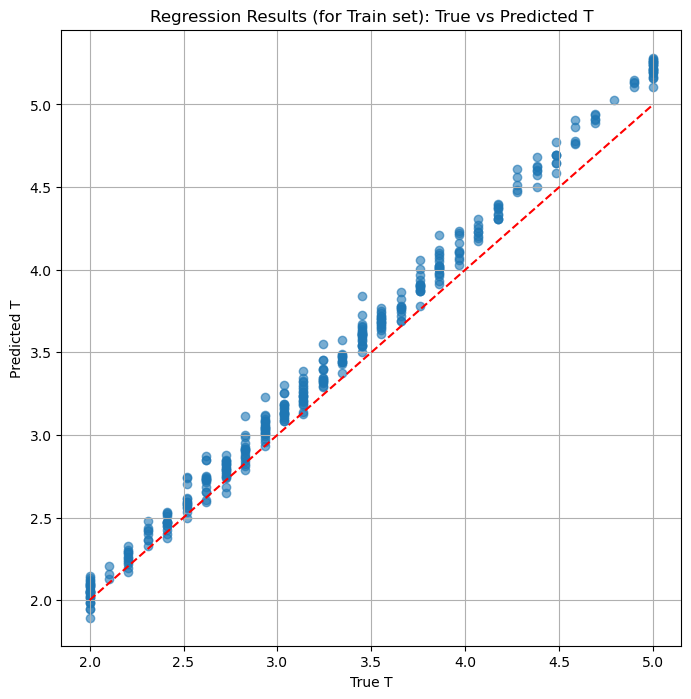

MAE: 0.5990, RMSE: 0.7679


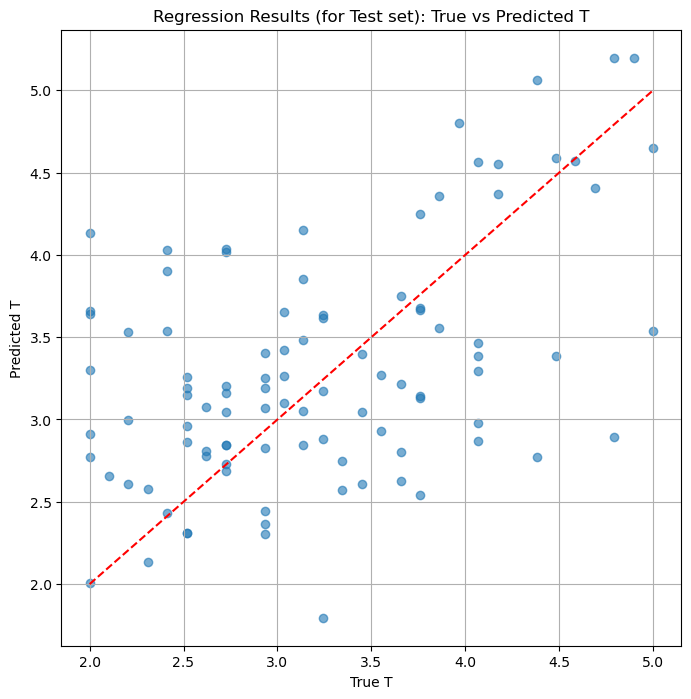

In [13]:
regressor.eval()

def plot_regression_results(y_true, y_pred, title):
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')

    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True T')
    plt.ylabel('Predicted T')
    plt.title(title)
    plt.grid(True)
    plt.show()

with torch.no_grad():
    y_pred = regressor(X_train).cpu().numpy()
    y_true = y_train.cpu().numpy()
    
    plot_regression_results(y_true, y_pred, 'Regression Results (for Train set): True vs Predicted T')

    y_pred = regressor(X_test).cpu().numpy()
    y_true = y_test.cpu().numpy()
    
    plot_regression_results(y_true, y_pred, 'Regression Results (for Test set): True vs Predicted T')

In [14]:
print(best_epoch)

94


Calculate PSNR with trained model

In [15]:
# LOL eval dataset's Ground Truth T values, based on PSNR
eval_gt = np.load(Path('/home/soom/CLODE/soom_npy_results') / 'eval_gt.npy')
print(eval_gt.shape)

(15, 2)


In [16]:
from torchmetrics.multimodal import CLIPImageQualityAssessment
from tqdm import tqdm
from misc import *
from network.conv_node import NODE

clode = NODE(device, (3, 256, 256), 32, augment_dim=0, time_dependent=True, adjoint=True)
clode.eval()
clode.to(device)
clode.load_state_dict(torch.load(f'pth/universal.pth', weights_only=True), strict=False)

prompts = ('brightness', 'noisiness', 'quality')
clip_metric = CLIPImageQualityAssessment(model_name_or_path="openai/clip-vit-base-patch16", prompts=prompts).to(device)

eval_path = Path('/home/soom/data/eval15')
img_labels = sorted(os.listdir(eval_path / 'low'))

def calculate_clip_scores(pred):    
    clip_result = clip_metric(pred.unsqueeze(0) if len(pred.shape) == 3 else pred)
    scores = [clip_result[prompt].item() for prompt in prompts]
    
    return np.array(scores)

iqa_scores = np.zeros((len(img_labels), NUM_T, 4))

T_values = np.linspace(2, 5, 30)

with torch.no_grad():
    for idx in tqdm(range(len(img_labels))):
        # save lq scores for error term
        lq = image_tensor(eval_path / 'low' / img_labels[idx], size=(256, 256))
        lq_scores = calculate_clip_scores(lq)
        # save enhanced image scores
        for T_idx, T in tqdm(enumerate(T_values), leave=False):
            integration_time = torch.tensor([0, T]).float().cuda()
            pred = clode(lq, integration_time, inference=True)['output'][0]
    
            scores = calculate_clip_scores(pred)
            iqa_scores[idx, T_idx, :3] = scores - lq_scores
            iqa_scores[idx, T_idx, 3] = T

np.save(Path('/home/soom/CLODE/soom_npy_results') / 'eval_iqa_scores.npy', iqa_scores)

/home/soom/miniconda3/envs/clode/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 15/15 [10:57<00:00, 43.81s/it]


In [18]:
iqa_scores[:3, :3, :]

array([[[-0.04969679,  0.00381809, -0.01785231,  2.        ],
        [-0.05320659,  0.00579897, -0.02032769,  2.10344828],
        [-0.05666907,  0.00791854, -0.02347028,  2.20689655]],

       [[-0.02277569,  0.00253254, -0.00375122,  2.        ],
        [-0.02539338,  0.00264639, -0.00444496,  2.10344828],
        [-0.02822447,  0.00279295, -0.00527757,  2.20689655]],

       [[-0.05492625,  0.06270376, -0.04195577,  2.        ],
        [-0.05921662,  0.07298738, -0.05295253,  2.10344828],
        [-0.06325623,  0.08130878, -0.06551617,  2.20689655]]])

In [19]:
X = torch.tensor(iqa_scores, dtype=torch.float32).to(device)
X[:, :, :-1] = (X[:, :, :-1] - X[:, :, :-1].mean(dim=1).unsqueeze(1)) / X[:, :, :-1].std(dim=1).unsqueeze(1)

y = eval_gt[:, 0]
y = torch.tensor(y, dtype=torch.float32).to(device)

MAE: 0.5462, RMSE: 0.6829


/home/soom/miniconda3/envs/clode/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_665342/2730559218.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glob

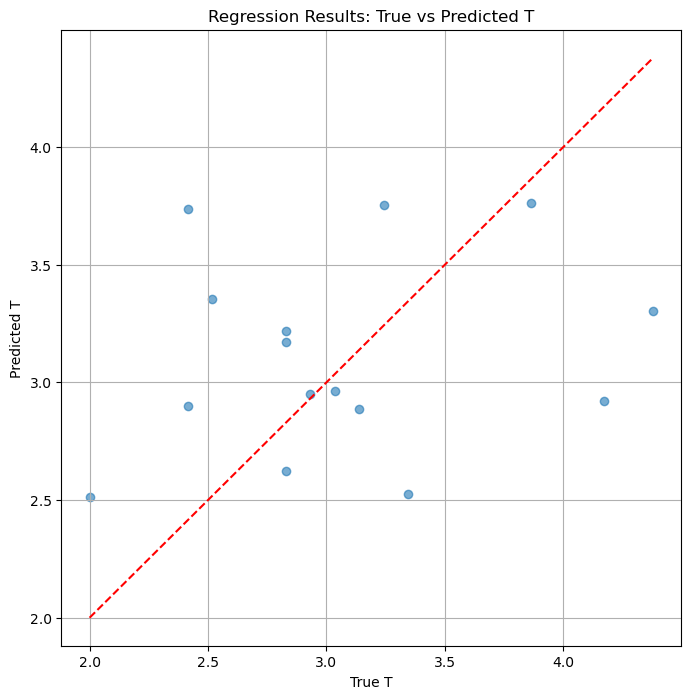

In [28]:
regressor = Regressor(input_dim = 4, hidden_dim = 64).to(device)
regressor.load_state_dict(torch.load(model_path / f'att_regression_{best_epoch}.pth'))
regressor.eval()

with torch.no_grad():
    y_pred = regressor(X).cpu().numpy()
    y_true = y.cpu().numpy()
    
    plot_regression_results(y_true, y_pred, 'Regression Results: True vs Predicted T')


In [29]:
print(y_pred.shape)
y_pred

(15,)


array([3.217421 , 2.888167 , 2.6233854, 2.5131295, 2.962401 , 2.9212599,
       3.1707327, 3.7364826, 3.3022373, 3.7628953, 2.9494674, 3.3540418,
       3.7529397, 2.8990943, 2.5262249], dtype=float32)

In [30]:
total_psnr = 0.0

with torch.no_grad():
    for idx in tqdm(range(len(img_labels))):
        # save lq scores for error term
        lq = image_tensor(eval_path / 'low' / img_labels[idx], size=(256, 256))
        gt = image_tensor(eval_path / 'high' / img_labels[idx], size=(256, 256))
        
        integration_time = torch.tensor([0, y_pred[idx]]).float().cuda()
        pred = clode(lq, integration_time, inference=True)['output'][0]
        psnr = calculate_psnr(pred, gt)
        total_psnr += psnr

print(f"average psnr: {total_psnr / len(img_labels):.4f}")

100%|██████████| 15/15 [00:18<00:00,  1.26s/it]

average psnr: 18.9647


In [26]:
gt_total_psnr = 0.0

with torch.no_grad():
    for idx in tqdm(range(len(img_labels))):
        # save lq scores for error term
        lq = image_tensor(eval_path / 'low' / img_labels[idx], size=(256, 256))
        gt = image_tensor(eval_path / 'high' / img_labels[idx], size=(256, 256))
        
        integration_time = torch.tensor([0, y_true[idx]]).float().cuda()
        pred = clode(lq, integration_time, inference=True)['output'][0]
        psnr = calculate_psnr(pred, gt)
        gt_total_psnr += psnr

print(f"average psnr: {gt_total_psnr / len(img_labels):.4f}")

100%|██████████| 15/15 [00:18<00:00,  1.24s/it]

average psnr: 24.2928


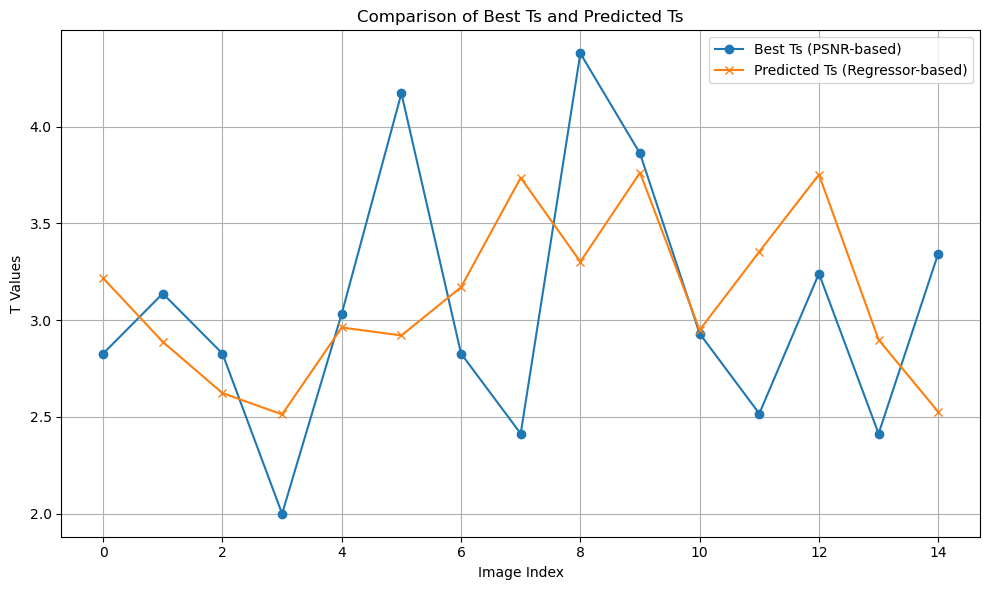

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Best Ts (PSNR-based)', marker='o')
plt.plot(y_pred, label='Predicted Ts (Regressor-based)', marker='x')
plt.xlabel('Image Index')
plt.ylabel('T Values')
plt.title('Comparison of Best Ts and Predicted Ts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()